# Sciplex3
In this notebook, we load the sciplex3 dataset (4 cell line 188 drugs, 4 dosages).
Count matrix contains about 1 007 419 688 (1 billion ) non zero elements and about 700 000 cells.

In [2]:
%pip install igraph

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 19.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 19.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import igraph

In [4]:
# change this to the directory that contains the datasets
data_dir = 'C:/Users/nbrouwer1/Documents/VS_projects/prepare_data/input_files/sciplex_selections/'

fn = data_dir + 'Srivatsan_2019_raw.h5ad'

adata = sc.read(fn)
adata

AnnData object with n_obs × n_vars = 581777 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'

AnnData object with n_obs × n_vars = 581777 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'
    uns: 'preprocessing_nb_link', 'doi'


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cell_type,581777,3,MCF7,292010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dose,581777.0,NaN,NaN,NaN,2442.078546,3998.180329,0.0,10.0,100.0,1000.0,10000.0
dose_character,581777,5,10,153013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dose_pattern,581777,4,4,156274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g1s_score,581777.0,NaN,NaN,NaN,1.51545,0.923619,0.0,0.915307,1.558071,2.174137,5.227012
g2m_score,581777.0,NaN,NaN,NaN,1.757476,0.923809,0.0,1.158509,1.815805,2.429784,4.718647
pathway,581777,22,Epigenetics,121599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pathway_level_1,581777,17,Epigenetic regulation,147875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pathway_level_2,581777,55,Histone deacetylation,97378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_dose,581777,753,Vehicle_0,13004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


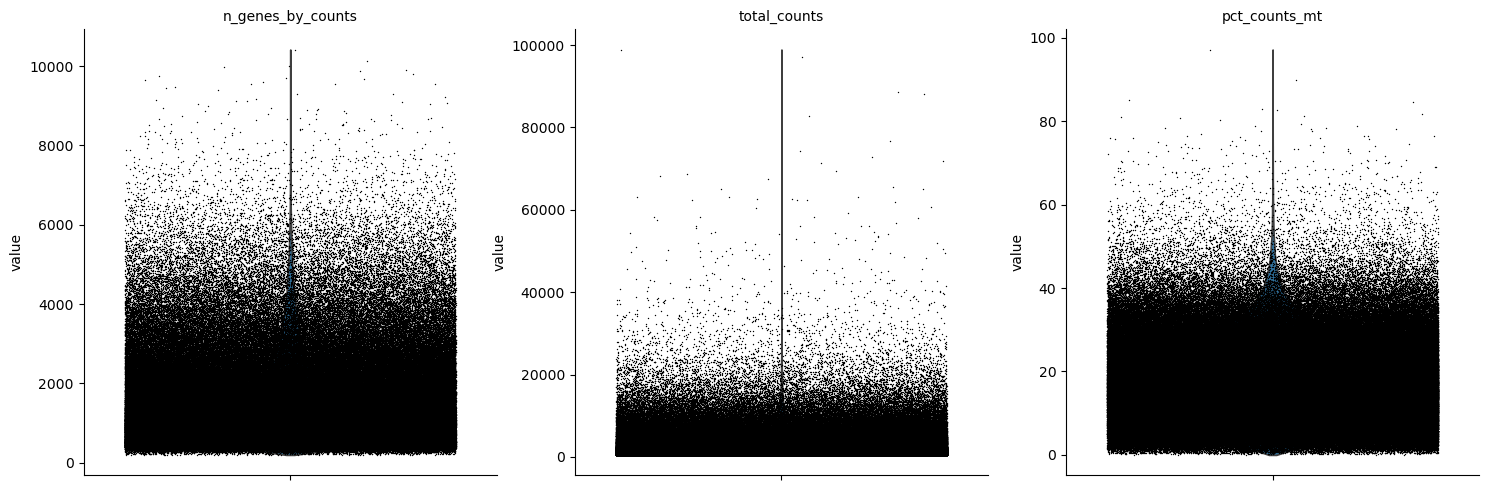

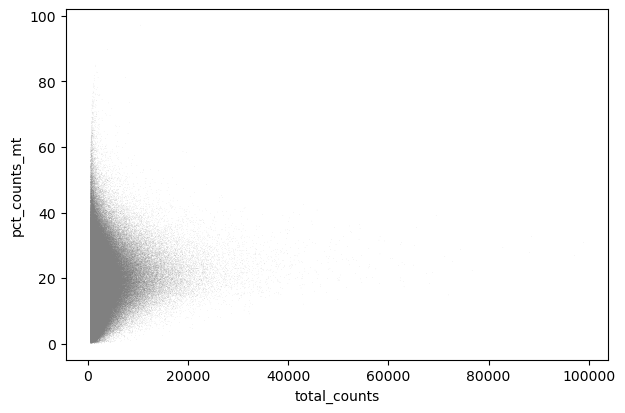

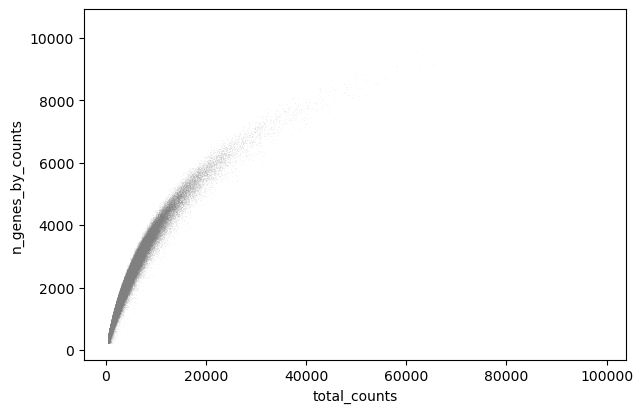

In [5]:
# metalabels
adata.uns['preprocessing_nb_link'] = f'https://nbviewer.org/github/theislab/sc-pert/blob/main/datasets/Srivatsan_2019_curation.ipynb'
is_counts = True
var_genes = None
doi = '10.1126/science.aax6234'
adata.uns['doi'] = doi
print(adata)
display(adata.obs.describe(include='all').T)

# filtering and processing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# use gene symbols as gene names
if var_genes:
    adata.var[var_genes] = adata.var[var_genes].astype(str)
    adata.var = adata.var.reset_index().set_index(var_genes)
    print(adata.var_names)
    
adata.var_names_make_unique()

In [6]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]  # edit
adata = adata[adata.obs.pct_counts_mt < 50]

In [8]:
if is_counts:
    adata.layers['counts'] = adata.X
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=False)
sc.pl.highly_variable_genes(adata)

KeyboardInterrupt: 

In [9]:
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)
# sc.tl.leiden(adata)
sc.tl.umap(adata)

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


The following fields are meant to serve as a template.

In [10]:
control = 'Vehicle'
replace_dict = {
    control: 'DMSO',  # most common control for small molecules, with its own strong effect
}
adata.obs['perturbation_name'] = [s.split(' (')[0].split('HCl')[0] for s in adata.obs.product_name]
adata.obs['perturbation_name'] = adata.obs['perturbation_name'].replace(replace_dict)
adata.obs['perturbation_name'].unique()

array(['Enzastaurin', 'Raltitrexed', 'DMSO', 'Lenalidomide',
       'Divalproex Sodium', 'MLN8054', 'Sodium Phenylbutyrate',
       'Celecoxib', 'Linifanib', 'Thalidomide', 'SNS-314', '(+)-JQ1',
       'S3I-201', 'AZD1480', 'PF-573228', 'CEP-33779', 'Resminostat',
       'Tie2 kinase inhibitor', 'Nintedanib', 'SRT3025 ', 'Avagacestat',
       'Quisinostat', 'MC1568', 'Temsirolimus', 'IOX2', 'Bosutinib',
       'Regorafenib', 'Aurora A Inhibitor I', 'ENMD-2076', 'Curcumin',
       'NVP-BSK805 2', 'Tozasertib', 'Crizotinib', 'Panobinostat',
       'Alvespimycin', 'Sorafenib Tosylate', 'Maraviroc', 'Baricitinib',
       'Mesna ', 'Fedratinib', 'Trametinib', 'Roscovitine',
       'S-Ruxolitinib', 'JNJ-26854165', 'Tofacitinib', 'Hesperadin',
       'UNC0379', 'TGX-221', 'Filgotinib', 'G007-LK', 'WHI-P154',
       'Triamcinolone Acetonide', 'BMS-911543', 'Flavopiridol ',
       'Ruxolitinib', 'CYC116', 'AT9283', 'PJ34', 'GSK-LSD1 2',
       'Droxinostat', 'Momelotinib', 'Azacitidine ', 'Roxa

In [11]:
adata.obs['perturbation_type'] = 'small molecule'
adata.obs['perturbation_value'] = adata.obs['dose']
adata.obs['perturbation_unit'] = 'ug'

In [12]:
adata.obs.columns

Index(['cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score',
       'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2',
       'product_dose', 'product_name', 'proliferation_index', 'replicate',
       'size_factor', 'target', 'vehicle', 'n_genes', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'perturbation_name',
       'perturbation_type', 'perturbation_value', 'perturbation_unit'],
      dtype='object')

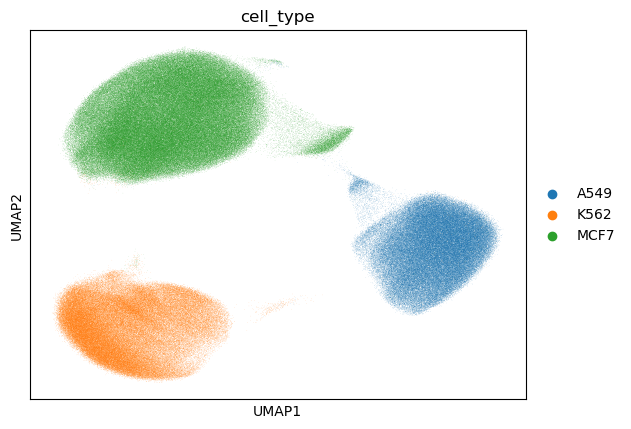

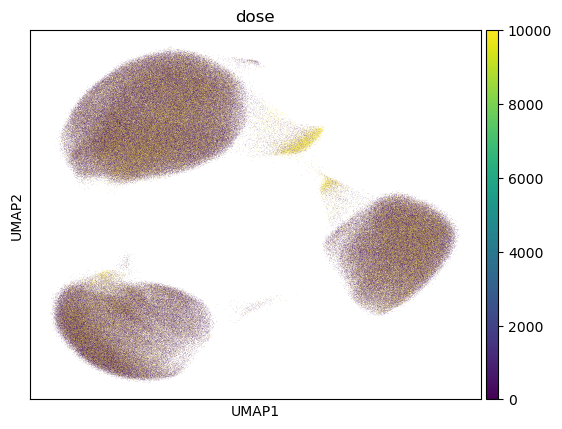

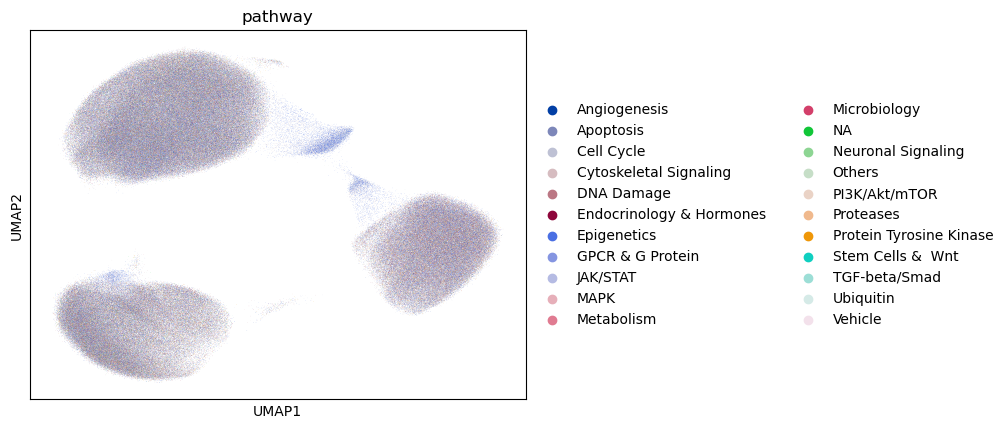

In [16]:
sc.pl.umap(adata, color='cell_type')
sc.pl.umap(adata, color='dose')
sc.pl.umap(adata, color='pathway')

c:\Users\nbrouwer1\Documents\VS_projects\prepare_data\.conda\lib\site-packages\scanpy\plotting\_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


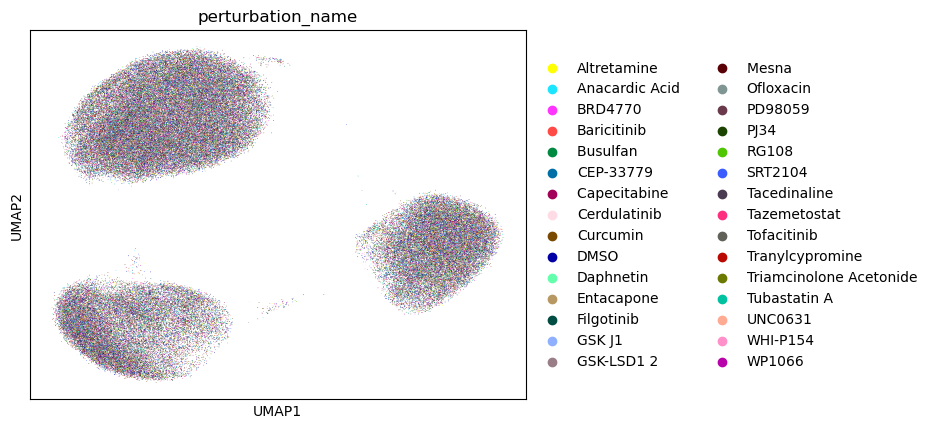

In [15]:
sc.pl.umap(
    adata[adata.obs.perturbation_name.isin((adata.obs.perturbation_name.value_counts().index[:30]))],
    color='perturbation_name')